In [97]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [71]:
#Import the data set.
df = pd.read_csv('breast_cancer.csv') #reference for original dataset.
X = pd.read_csv('breast_cancer.csv') #working dataset.

In [72]:
X.columns

Index([u'Unnamed: 0', u'id number', u'clump_thickness',
       u'uniformity_of_cell_size', u'uniformity_of_cell_shape',
       u'marginal_adhesion', u'epithelial_cell_size', u'bare_nuclei',
       u'bland_chromatin', u'normal_nucleoli', u'mitoses', u'malignant'],
      dtype='object')

In [73]:
X.drop(["Unnamed: 0", "id number"], axis=1, inplace=True)

In [74]:
X.columns

Index([u'clump_thickness', u'uniformity_of_cell_size',
       u'uniformity_of_cell_shape', u'marginal_adhesion',
       u'epithelial_cell_size', u'bare_nuclei', u'bland_chromatin',
       u'normal_nucleoli', u'mitoses', u'malignant'],
      dtype='object')

In [75]:
y = X.pop("malignant")

In [76]:
X.columns

Index([u'clump_thickness', u'uniformity_of_cell_size',
       u'uniformity_of_cell_shape', u'marginal_adhesion',
       u'epithelial_cell_size', u'bare_nuclei', u'bland_chromatin',
       u'normal_nucleoli', u'mitoses'],
      dtype='object')

In [77]:
# Make train and test datasets
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [78]:
#Quick and dirty benchmark
model = RandomForestRegressor(random_state=40)
model.fit(X_train, y_train)
print "R^2:", model.score(X_test, y_test).round(2)

R^2: 0.7


In [80]:
print "\n\n---Random Forest Model---"
#Random Forest AUC
rf_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print "Random Forest AUC = %2.2f" % rf_roc_auc



---Random Forest Model---
Random Forest AUC = 0.95


## Grid Search

In [81]:
### Grid Search
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [82]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [84]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
best_rfc = estimator.best_estimator_

In [86]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.914285714286


In [87]:
y_hat = best_rfc.predict(X_test)

In [90]:
correct = 0
total = y_test.shape[0]
for pred_val, truth_val in zip(y_hat, y_test):
    if pred_val == truth_val:
        correct +=1

print correct / float(total)

0.914285714286


In [91]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93        83
          1       0.89      0.89      0.89        57

avg / total       0.91      0.91      0.91       140



In [92]:
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[77  6]
 [ 6 51]]


**Precision:**  51 / (51 + 6) = .89

**Recall:**   51 / (51 + 6) = .89

In [94]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.972310293807


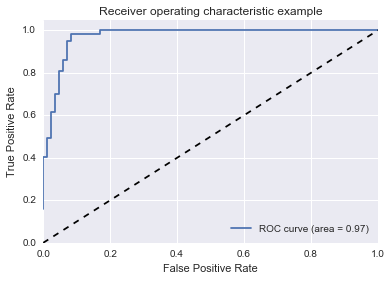

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## K-Fold

In [105]:
scores = cross_validation.cross_val_score(best_rfc, X, y, cv=10)

In [106]:
scores

array([ 0.91549296,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.97142857,  0.97142857,  0.98571429,  0.98550725,  0.98550725])

In [107]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.965794 +/-  0.018764
95 percent probability that if this experiment were repeated over and over the average score would be between 0.947030 and 0.984558


### Final Thoughts

My single holdout AUC score was 0.972310293807 and my K-Fold Cross Validation score ended up being 0.965794 +/- 0.018764.

I feel my model performed farely well. It came out with an average Precision and Recall of 0.91. While my single holdout AUC score was 0.97231. This score was within the range of my K-Fold cross validation range which had an upper bound of 0.984558 and a lower bound of 0.94703. 